## load data

In [2]:
import pandas as pd
from pathlib import Path

# Set your data folder
data_folder = Path("C:/Users/Rebal/Desktop/למודים/data lab/sanitec-warrenty-predector/data/raw")

# Define file names
file_names = {
    "orders": "rebal_orders_cleaned.parquet",  # Already converted
    "customers": "rebal_customers.csv",
    "items": "rebal_items.csv",
    "service": "rebal_service.csv",
    "suppliers": "rebal_suppliers.csv",
    "workers": "rebal_workers.csv"
}

# Load each file
print("\n🔄 Loading datasets...\n")
orders_df = pd.read_parquet(data_folder / file_names["orders"])
customers_df = pd.read_csv(data_folder / file_names["customers"], low_memory=False)
items_df = pd.read_csv(data_folder / file_names["items"], low_memory=False)
service_df = pd.read_csv(data_folder / file_names["service"], low_memory=False)
suppliers_df = pd.read_csv(data_folder / file_names["suppliers"], low_memory=False)
workers_df = pd.read_csv(data_folder / file_names["workers"], low_memory=False)

# Display basic info
for name, df in {
    "Orders": orders_df,
    "Customers": customers_df,
    "Items": items_df,
    "Service Calls": service_df,
    "Suppliers": suppliers_df,
    "Workers": workers_df
}.items():
    print(f"📁 {name} → Shape: {df.shape}")
    print(df.head(2), "\n")



🔄 Loading datasets...

📁 Orders → Shape: (375740, 1068)
   U_SPLEmpID  DocEntry  DocNum DocType CANCELED Handwrtten Printed DocStatus  \
0          62     19399  194397       I        N          N       N         C   
1          62     19399  194397       I        N          N       N         C   

  InvntSttus Transfered  ...  U_E_DiscPrcnt U_IsBtoB.1 U_IDBtoB.1  \
0          C          N  ...            NaN        NaN        NaN   
1          C          N  ...            NaN        NaN        NaN   

   U_InstllTyp U_IsAccept U_E_PriceCred U_PriceList  U_DelNo  U_APILineNum  \
0          NaN        NaN           NaN         NaN      NaN           NaN   
1          NaN        NaN           NaN         NaN      NaN           NaN   

   U_DaysSupply  
0           NaN  
1           NaN  

[2 rows x 1068 columns] 

📁 Customers → Shape: (462, 8)
   CardCode          CardName  GroupCode   Address ZipCode  \
0     50103  בית הקרמיקה יבנה        117   ת.ד 479     NaN   
1     50689    מ.דוכי

## Clean & Reduce Columns 
-remove columns with = 100% nulls.


In [3]:
def clean_model_df(df, name="DataFrame"):
    # Drop fully null columns
    null_cols = df.columns[df.isnull().all()].tolist()
    if null_cols:
        print(f"🧹 {name}: Dropping {len(null_cols)} fully-null columns: {null_cols[:5]}{'...' if len(null_cols) > 5 else ''}")
    else:
        print(f"✅ {name}: No fully-null columns found.")
    return df.drop(columns=null_cols)


## Check result

In [4]:



orders_df = clean_model_df(orders_df)
service_df = clean_model_df(service_df)
items_df = clean_model_df(items_df)
suppliers_df = clean_model_df(suppliers_df)
customers_df = clean_model_df(customers_df)
workers_df = clean_model_df(workers_df)


🧹 DataFrame: Dropping 418 fully-null columns: ['Ref2', 'TransId', 'ReceiptNum', 'Filler', 'StampNum']...
✅ DataFrame: No fully-null columns found.
🧹 DataFrame: Dropping 94 fully-null columns: ['frozenFrom', 'frozenTo', 'ValidComm', 'FrozenComm', 'ExpensAcct']...
✅ DataFrame: No fully-null columns found.
✅ DataFrame: No fully-null columns found.
✅ DataFrame: No fully-null columns found.


## Meraging the data

In [5]:
def build_modeling_table(orders_df, service_df, items_df, suppliers_df, customers_df, workers_df):
    # 1. Merge service data to orders to get itemcode
    merged = orders_df.merge(
        service_df[["U_OrEntry", "itemCode"]],
        how="left",
        left_on="DocEntry",
        right_on="U_OrEntry"
    )

    # 2. Merge with workers (technicians)
    merged = merged.merge(
        workers_df,
        how="left",
        left_on="U_SPLEmpID",
        right_on="empID",
        suffixes=("", "_worker")
    )

    # 3. Merge with customers
    merged = merged.merge(
        customers_df,
        how="left",
        on="CardCode",
        suffixes=("", "_customer")
    )

    # 4. Merge with items (via itemcode from service)
    merged = merged.merge(
        items_df,
        how="left",
        left_on="itemCode",
        right_on="ItemCode",
        suffixes=("", "_item")
    )

    # 5. Merge items with suppliers (and bring into merged)
    items_with_suppliers = items_df.merge(
        suppliers_df,
        how="left",
        on="CardCode",
        suffixes=("", "_supplier")
    )

    # Merge item-supplier info back into final merged DataFrame
    merged = merged.merge(
        items_with_suppliers,
        how="left",
        left_on="itemCode",
        right_on="ItemCode",
        suffixes=("", "_item_supplier")
    )

    print(f"✅ Final shape: {merged.shape}")
    return merged


## Check result

In [6]:
model_df = build_modeling_table(
    orders_df, service_df, items_df, suppliers_df, customers_df, workers_df
)



✅ Final shape: (400913, 1003)


In [7]:
print(model_df.columns)

Index(['U_SPLEmpID', 'DocEntry', 'DocNum', 'DocType', 'CANCELED', 'Handwrtten',
       'Printed', 'DocStatus', 'InvntSttus', 'Transfered',
       ...
       'U_slcName_item_supplier', 'U_Floor_item_supplier',
       'U_Category_item_supplier', 'U_SubCategory_item_supplier',
       'U_need_measure_item_supplier', 'U_maxdisc1_item_supplier',
       'CardName_item_supplier', 'GroupCode_item_supplier',
       'Address_item_supplier', 'CntctPrsn_item_supplier'],
      dtype='object', length=1003)


## Create target variable

In [8]:
# Create binary target based on whether DocEntry appears in service calls
service_order_ids = service_df["U_OrEntry"].dropna().unique()
model_df["has_service_call"] = model_df["DocEntry"].isin(service_order_ids).astype(int)

# Check the result
print("✅ Target created. Distribution:")
print(model_df["has_service_call"].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')


✅ Target created. Distribution:
has_service_call
0    69.97%
1    30.03%
Name: proportion, dtype: object


c:\Users\Rebal\anaconda3\envs\datalabpaper\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


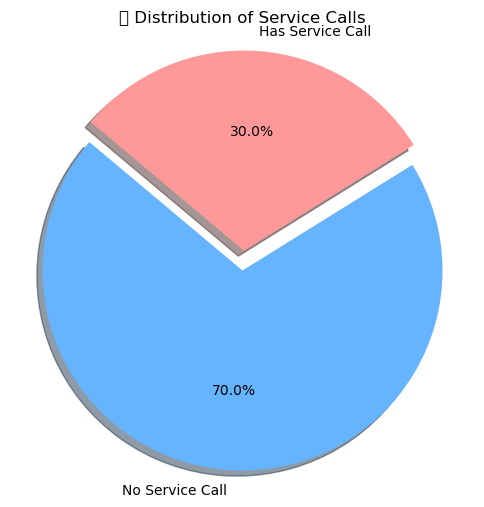

In [9]:
import matplotlib.pyplot as plt

# Value counts with labels
service_call_counts = model_df["has_service_call"].value_counts()
labels = ["No Service Call", "Has Service Call"]
colors = ["#66b3ff", "#ff9999"]

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    service_call_counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    explode=[0.05, 0.05],
    shadow=True
)
plt.title("📊 Distribution of Service Calls")
plt.axis("equal")  # Equal aspect ratio ensures the pie is a circle.
plt.show()


In [10]:
print(model_df.shape)

(400913, 1004)


## remove features with low var (0.01)

In [11]:
# Step 1: Separate target
y = model_df["has_service_call"]
X = model_df.drop(columns=["has_service_call"])

# Step 2: Keep only numeric columns
X_numeric = X.select_dtypes(include=["number"])
print(f"🔵 Before variance filter: {X_numeric.shape}")

# Step 3: Apply variance threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X_numeric)

# Step 4: Restore column names and index
selected_cols = X_numeric.columns[selector.get_support()]
X_numeric_reduced = pd.DataFrame(X_reduced, columns=selected_cols, index=model_df.index)
print(f"✅ After variance filter: {X_numeric_reduced.shape}")

# Step 5: Combine reduced numeric with other columns (non-numeric)
X_other = X.drop(columns=X_numeric.columns)
model_df = pd.concat([X_numeric_reduced, X_other], axis=1)
model_df["has_service_call"] = y  # Add target back

# Final check
print(f"🧩 Final model_df shape: {model_df.shape}")


🔵 Before variance filter: (400913, 564)
✅ After variance filter: (400913, 200)
🧩 Final model_df shape: (400913, 640)


In [12]:
print(model_df.shape)

(400913, 640)


## drop duplicate columns

In [13]:
def summarize_drops(df, dropped_cols, step_name, table_name):
    total_before = df.shape[1] + len(dropped_cols)
    print(f"{table_name} | {step_name}: Dropped {len(dropped_cols)} columns out of {total_before} → Remaining: {df.shape[1]}")
    
def drop_duplicate_columns(df, table_name):
    df_T = df.T
    duplicated = df_T[df_T.duplicated()].index.tolist()
    df_cleaned = df.drop(columns=duplicated)
    summarize_drops(df_cleaned, duplicated, "Step 3 (Duplicate columns)", table_name)
    return df_cleaned

In [14]:
model_df = drop_duplicate_columns(model_df, "Model DF")

Model DF | Step 3 (Duplicate columns): Dropped 261 columns out of 640 → Remaining: 379


In [15]:
print(model_df.shape)

(400913, 379)


## Items with most service calls

In [16]:
# Filter only rows with service call = 1
service_calls = model_df[model_df["has_service_call"] == 1]

# Group by ItemCode and ItemName and count occurrences
item_service_counts = (
    service_calls.groupby(["itemCode", "ItemName"])
    .size()
    .reset_index(name="service_call_count")
    .sort_values(by="service_call_count", ascending=False)
)

# Display top 10 items with most service calls
item_service_counts.head(10)


,itemCode,ItemName,service_call_count
968,1216116C104,קליר תחתון + כיור 102 צבע .א לבן מבריק,11380
2004,8010412G11,נפטון - מקלחון מרובע 77-79.5 זכוכית גרניט,2324
1614,1421415C104,קליאו תחתון + כיור 82 צבע .א לבן מבריק,2171
1615,1421416C104,קליאו תחתון + כיור 102 צבע .א לבן מבריק,1720
2071,8012020G14,לוטוס-כנף לאמבטיה 120 זכוכית צרוב רוחב,1718
908,1153215C104K10E164,ליאם 109 -קומפלט 82 צבע .א לבן מבריק צבע.כ חרס...,1694
2199,8211217K10P10,סקיני -כיור 120 צבע.כ חרס לבן חור מרכז,1251
2015,8010714G15,פלוטו -מקלחון עגול 85-87 זכוכית צרוב קוביות,1246
2006,8010412G14,נפטון - מקלחון מרובע 77-79.5 זכוכית צרוב רוחב,1245
1784,4910116E164,109- מראה 100/60 צבע.מ ללא,1233


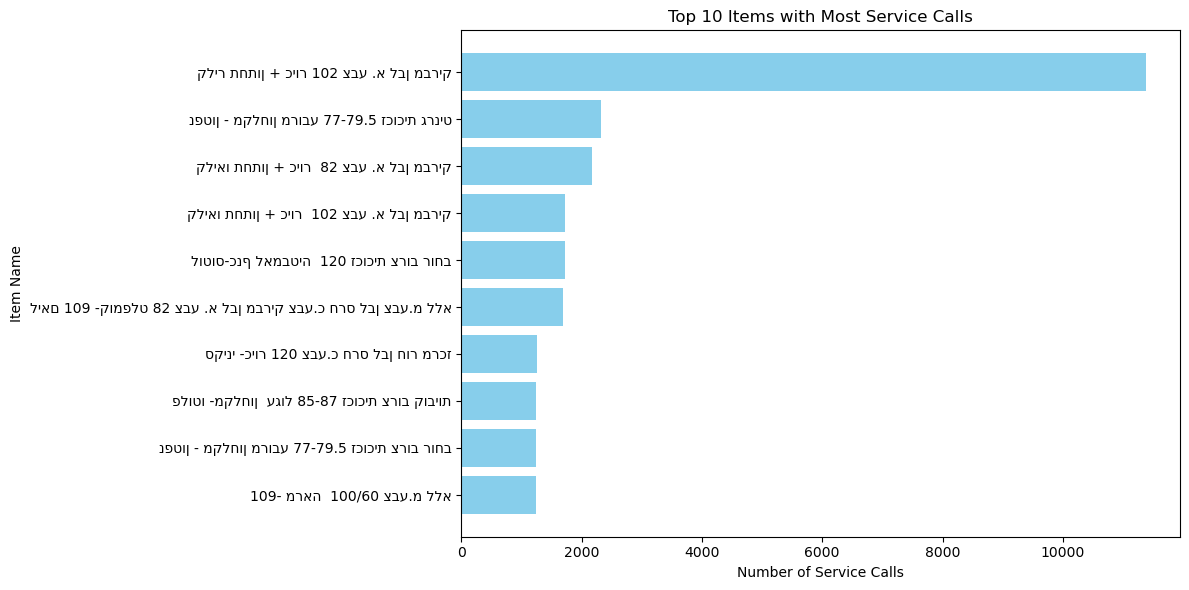

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter rows with service calls
service_calls = model_df[model_df["has_service_call"] == 1]

# Group by itemCode and ItemName, count service calls
item_service_counts = (
    service_calls.groupby(["itemCode", "ItemName"])
    .size()
    .reset_index(name="service_call_count")
    .sort_values(by="service_call_count", ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(item_service_counts["ItemName"], item_service_counts["service_call_count"], color='skyblue')
plt.xlabel("Number of Service Calls")
plt.ylabel("Item Name")
plt.title("Top 10 Items with Most Service Calls")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()


## Year with most service calls

📅 Year with most service calls: 2013 (30,694 calls)


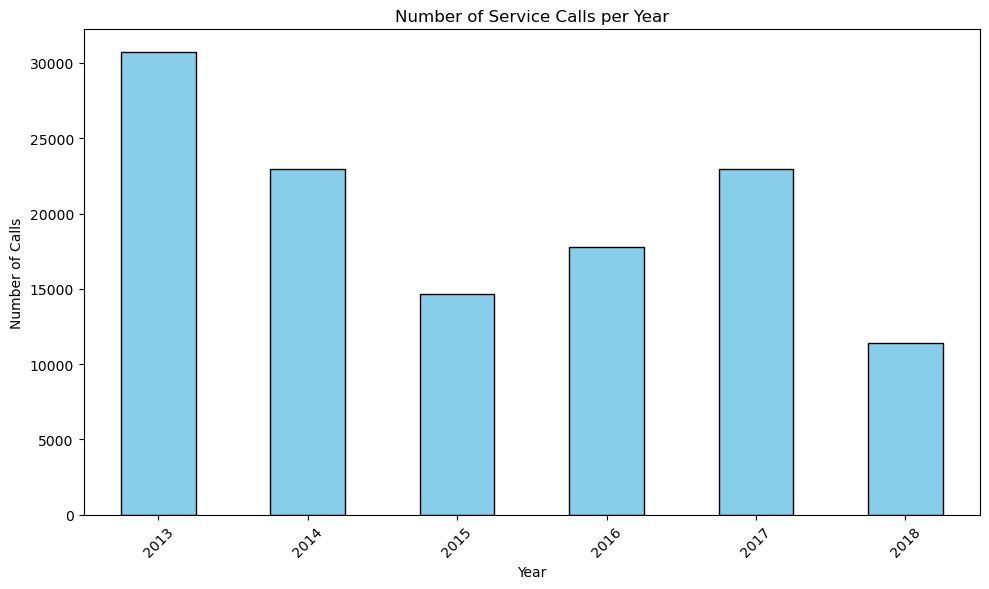

In [18]:
# Step 1: Filter only service calls
service_calls = model_df[model_df["has_service_call"] == 1].copy()

# Step 2: Make sure the date column is in datetime format
# Replace 'StartDate' with your actual column name if different
service_calls["service_date"] = pd.to_datetime(service_calls["CreateDate"], errors="coerce")

# Step 3: Extract year
service_calls["service_year"] = service_calls["service_date"].dt.year

# Step 4: Count service calls per year
year_counts = service_calls["service_year"].value_counts().sort_index()

# Step 5: Display the year with the most service calls
most_calls_year = year_counts.idxmax()
most_calls_count = year_counts.max()

print(f"📅 Year with most service calls: {most_calls_year} ({most_calls_count:,} calls)")

# Optional: plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
year_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Service Calls per Year")
plt.xlabel("Year")
plt.ylabel("Number of Calls")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## which installers had the most service calls 

In [19]:
# 1. Filter rows with service calls
service_calls = model_df[model_df["has_service_call"] == 1]

# 2. Group by installer column (e.g., U_SPLEmpID)
installer_counts_named = (
    service_calls.groupby(["U_SPLEmpID", "firstName", "lastName"])
    .size()
    .reset_index(name="service_call_count")
    .sort_values(by="service_call_count", ascending=False)
)
print("🔧 Top installers by service calls:")
installer_counts_named.head(10)
# 3. Display top 10 installers




🔧 Top installers by service calls:


,U_SPLEmpID,firstName,lastName,service_call_count
6,60.0,מייקל,חמאתי,14545
7,61.0,אורי,אביב,11921
11,69.0,רועי,ממן,11000
1,51.0,איתן,סעדה,10557
15,84.0,רוברט ורודני,זיתונה,10539
16,99.0,שי,יחזקאל,9619
13,72.0,סווהיב,עודה,9259
8,62.0,אמירם,קטן,8322
26,166.0,אליאור,לוי,7464
10,64.0,אודי,סינוואני,3327


C:\Users\Rebal\AppData\Local\Temp\ipykernel_13196\2956252904.py:18: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Rebal\anaconda3\envs\datalabpaper\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


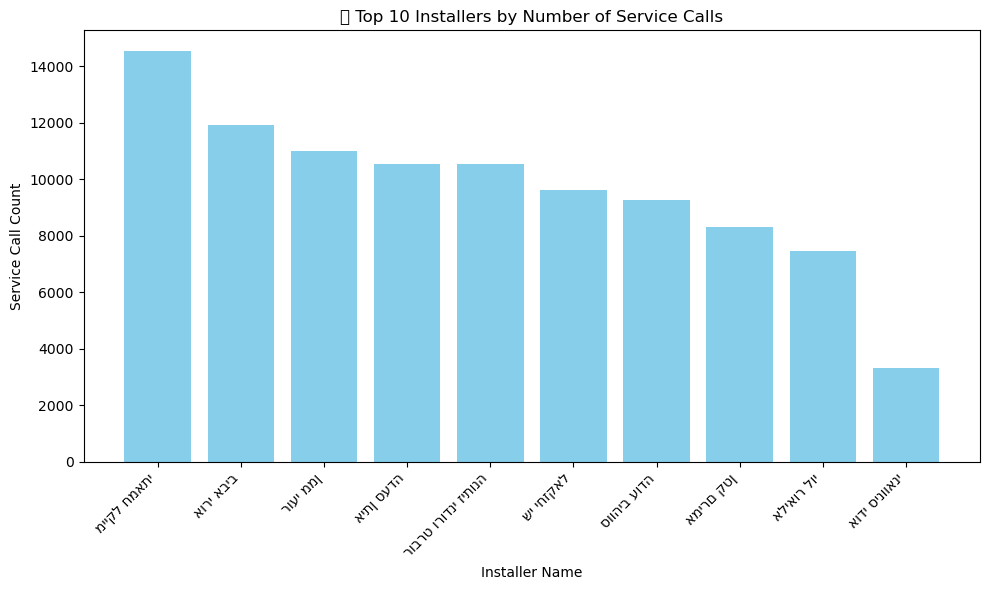

In [20]:
import matplotlib.pyplot as plt

# Combine first and last names into a single label
installer_counts_named["Installer"] = (
    installer_counts_named["firstName"].fillna('') + " " + installer_counts_named["lastName"].fillna('')
)

# Get top 10
top_installers = installer_counts_named.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_installers["Installer"], top_installers["service_call_count"], color="skyblue")
plt.title("🔧 Top 10 Installers by Number of Service Calls")
plt.xlabel("Installer Name")
plt.ylabel("Service Call Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [21]:
model_df.to_parquet('C:/Users/Rebal/Desktop/למודים/data lab/sanitec-warrenty-predector/data/processed/model_df_clean.parquet', index=False)
